In [4]:
import pandas as pd
import numpy as np
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

df = pd.read_json('../datasets/7_dataset.json')
df = df[:50000]
df = df.fillna(method='ffill')
print(df.head())

   Sentence #           Word         Lemma   POS  Tag     Dep  Polarity Label
0           0             At            at   ADV   RB  advmod  0.000000     W
1           0          least         least   ADV  RBS  advmod  0.000000     W
2           0            two           two   NUM   CD  nummod  0.000000     W
3           0  organizations  organization  NOUN  NNS   nsubj -0.193345     W
4           0           have          have   AUX  VBP     aux -0.046438     W


In [8]:
df['Sentence #'].nunique(), df.Word.nunique(), df.Tag.nunique()
df.groupby('Label').size().reset_index(name='counts')

,Label,counts
0,M,27451
1,W,22549


In [11]:
X = df.drop('Label', axis=1)
y = df.Label.values
classes = np.unique(y)
classes = classes.tolist()

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=0)
#X_train.shape, y_train.shape

['M', 'W']


In [35]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, l, p, t, d, pol) for w, l, p, t, d, pol in zip( s['Word'].values.tolist(),
                                                            s['Lemma'].values.tolist(),
                                                            s['POS'].values.tolist(), 
                                                            s['Tag'].values.tolist(),
                                                            s['Dep'].values.tolist(),
                                                            s['Polarity'].values.tolist()
                                                            )]
        self.grouped = self.data.groupby('Sentence #').apply(agg_func)
        self.sentences = [s for s in self.grouped]
        
getter = SentenceGetter(df)
sentences = getter.sentences

In [40]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    
    features = {
        'word.lower()': word.lower(), 
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True
    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]
def sent2labels(sent):
    return [label for _, _, _, _, _, label in sent]
def sent2tokens(sent):
    return [token for token, _, _ in sent]

In [42]:
X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [8]:
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV

crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
param_distributions = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

f1_scorer = make_scorer(metrics.flat_f1_score, average='weighted', labels=classes)

rs = RandomizedSearchCV(crf, param_distributions, cv=3, verbose=1,n_jobs=-1, n_iter=50, scoring=f1_scorer)
rs.fit(X_train, y_train)

print('best params:', rs.best_params_)

crf = rs.best_estimator_
y_pred = crf.predict(X_test)

C:\Users\Rasmu\anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 14.6min finished


best params: {'c1': 0.21632995217739043, 'c2': 0.06552513616458658}


In [9]:
print(metrics.flat_classification_report(y_test, y_pred, labels = new_classes))

C:\Users\Rasmu\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=['B-art', 'B-eve', 'B-geo', 'B-gpe', 'B-nat', 'B-org', 'B-per', 'B-tim', 'I-art', 'I-eve', 'I-geo', 'I-gpe', 'I-nat', 'I-org', 'I-per', 'I-tim'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


              precision    recall  f1-score   support

       B-art       0.40      0.12      0.18        68
       B-eve       0.56      0.27      0.37        66
       B-geo       0.85      0.91      0.88      5798
       B-gpe       0.95      0.91      0.93      2487
       B-nat       0.53      0.26      0.35        38
       B-org       0.80      0.72      0.76      3163
       B-per       0.84      0.82      0.83      2644
       B-tim       0.93      0.87      0.89      3170
       I-art       0.11      0.03      0.05        65
       I-eve       0.45      0.17      0.24        60
       I-geo       0.82      0.79      0.80      1193
       I-gpe       0.83      0.42      0.56        45
       I-nat       0.50      0.25      0.33        16
       I-org       0.80      0.78      0.79      2711
       I-per       0.82      0.90      0.86      2691
       I-tim       0.82      0.72      0.77       963

   micro avg       0.85      0.83      0.84     25178
   macro avg       0.69   

In [10]:
import eli5
eli5.show_weights(crf, top=10)

C:\Users\Rasmu\anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


From \ To,O,B-art,I-art,B-eve,I-eve,B-geo,I-geo,B-gpe,I-gpe,B-nat,I-nat,B-org,I-org,B-per,I-per,B-tim,I-tim
O,4.812,0.504,-3.046,0.671,-2.646,1.519,-6.028,0.532,-2.355,0.355,-2.117,1.363,-6.011,1.992,-4.866,1.811,-5.434
B-art,-0.064,0.0,6.397,0.0,0.0,-0.463,-0.095,-0.384,0.0,0.0,0.0,0.0,-1.018,-1.596,-0.92,0.0,-0.068
I-art,-0.564,-0.291,5.98,0.0,0.0,-0.038,-0.123,-0.583,0.0,0.0,0.0,-0.854,-1.22,-1.821,-1.206,0.0,-0.695
B-eve,-0.541,0.0,0.0,0.0,6.042,-0.593,0.0,-1.163,0.0,0.0,0.0,-1.054,-0.575,-1.426,-1.315,-0.191,-0.704
I-eve,-0.111,0.0,0.0,-1.598,5.374,-0.514,0.0,-0.357,0.0,0.0,0.0,-0.355,-0.773,-0.869,-0.219,-0.577,-0.316
B-geo,0.57,0.996,-1.63,-0.858,-1.781,-3.571,5.658,-0.502,-2.985,0.0,-0.696,-1.19,-3.969,-1.684,-3.614,1.129,-2.863
I-geo,-0.206,0.433,-0.742,-0.0,-1.052,-2.653,4.328,-2.606,-0.722,0.0,0.0,-0.782,-2.971,-0.833,-2.748,0.007,-2.084
B-gpe,0.712,-1.694,-1.512,-0.574,-1.97,-0.878,-3.898,-5.415,3.956,-0.669,-0.641,0.168,-4.664,-1.006,-3.839,-0.296,-2.181
I-gpe,-0.351,0.0,0.0,0.0,0.0,-0.384,0.0,-0.891,3.405,0.0,0.0,-0.465,-0.286,-0.411,-0.001,-0.733,0.0
B-nat,-0.908,0.0,0.0,0.0,0.0,0.0,0.0,-0.762,0.0,0.0,6.663,0.0,0.0,-0.767,-0.217,-0.212,0.0


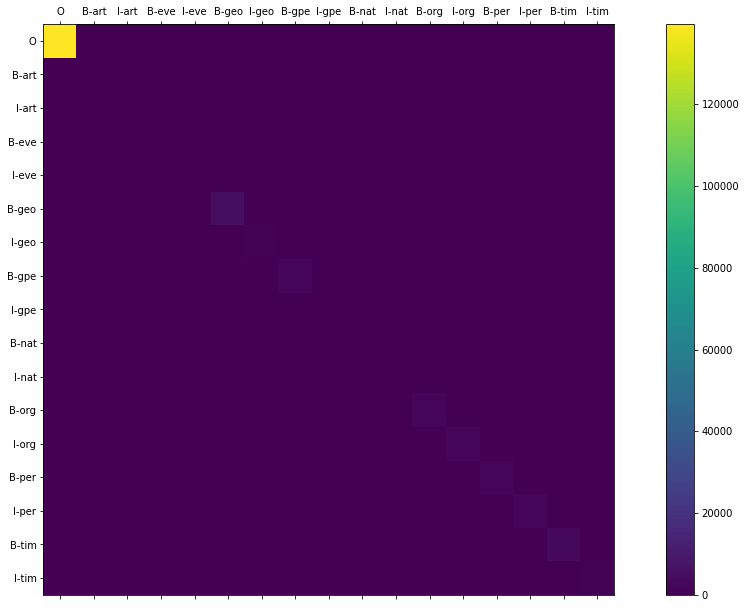

In [30]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

flat_list_test = [item for sublist in y_test for item in sublist]
flat_list_pred = [item for sublist in y_pred for item in sublist]


sortedLabels = ['O', 'B-art','I-art','B-eve','I-eve','B-geo','I-geo','B-gpe','I-gpe','B-nat','I-nat','B-org','I-org','B-per','I-per','B-tim','I-tim']
cm = confusion_matrix(flat_list_test, flat_list_pred, labels=sortedLabels)

fig = plt.figure( figsize=[18.5,10.5])
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
fig.colorbar(cax)
ax.set_xticklabels(sortedLabels)
ax.set_yticklabels(sortedLabels)

ax = plt.xticks(np.arange(0, 17))
ax = plt.yticks(np.arange(0, 17))

